# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

이번 실습에서는 HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.
먼저 필요한 library들을 설치하고 import합니다.

In [3]:
!pip install transformers datasets evaluate accelerate scikit-learn

In [4]:
import random
import evaluate
import numpy as np
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split


/opt/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

n_labels = 3
batch_size = 64
max_len = 400
lr = 2e-5
n_epochs = 10

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='mps')

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [6]:
data = load_dataset("nyu-mll/glue", "mnli")
data

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

`load_dataset`은 HuggingFace의 `datasets` library의 함수로, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.
출력 결과를 보시면 `imdb`는 `train`, `test`, 그리고 `unsupervised` data로 구성되어있습니다.
이 중에서 우리는 `train`과 `test`를 활용합니다.

`train` data를 한 번 살펴보겠습니다.

In [7]:
train_df = pd.DataFrame(data["train"]) 
train_df.tail(5)

,premise,hypothesis,label,idx
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,392697
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,392698
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,392699
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,392700
392701,in that other you know uh that i should do it ...,My husband has been so overworked lately that ...,1,392701


In [8]:
train_df, test_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df["label"])
val_df, test_df = train_test_split(test_df, test_size=0.3333, random_state=42, stratify=test_df["label"])

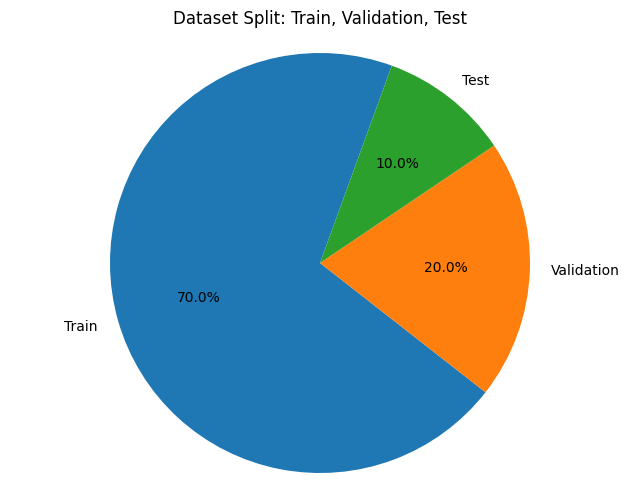

In [9]:
import matplotlib.pyplot as plt

# Mocking dataset lengths as per the discussion since data is no longer available
train_size = len(train_df)
val_size =len(val_df)
test_size = len(test_df)

# Sizes for train, val, and test
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=70)
plt.title("Dataset Split: Train, Validation, Test")
plt.axis('equal')  # Ensure the pie chart is a perfect circle
plt.show()

In [10]:
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:

from datasets import Dataset

#Hugging Face Dataset 포멧 전환
train_hf_df = Dataset.from_pandas(train_df)
val_hf_df = Dataset.from_pandas(val_df)
test_hf_df = Dataset.from_pandas(test_df)


In [12]:
# tokenize and embedding
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length")
     

Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.

In [13]:
#train, val, test 전처리
train_hf_df = train_hf_df.map(preprocess_function, batched=True)
val_hf_df = val_hf_df.map(preprocess_function, batched=True)
test_hf_df = test_hf_df.map(preprocess_function, batched=True)

Map: 100%|██████████████████████| 39267/39267 [00:03<00:00, 10571.76 examples/s]


In [14]:
train_hf_df

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 274891
})

In [15]:
train_df = train_hf_df.remove_columns(["premise", "hypothesis", "idx"])
val_df = val_hf_df.remove_columns(["premise", "hypothesis", "idx"])
test_df = test_hf_df.remove_columns(["premise", "hypothesis", "idx"])

In [16]:

#PyTorch tensor
train_df.set_format("torch")
val_df.set_format("torch")
test_df.set_format("torch")

In [17]:
print(model.config)  # 모델의 파라미터를 구조 보기

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.3",
  "vocab_size": 30522
}



HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.

In [18]:
from transformers import DistilBertConfig, DistilBertModel

# Initializing a DistilBERT configuration
configuration = DistilBertConfig()

# Initializing a model (with random weights) from the configuration
model = DistilBertModel(configuration)

# Accessing the model configuration
configuration = model.config

In [19]:

print(model.config)

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.46.3",
  "vocab_size": 30522
}



In [20]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',            # 모델, log 등을 저장할 directory
    num_train_epochs= n_epochs,             # epoch 수
    per_device_train_batch_size=batch_size, # training data의 batch size
    per_device_eval_batch_size=batch_size,  # validation data의 batch size
    logging_strategy="epoch",               # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,                          # 학습을 진행하겠다는 의미
    do_eval=True,                           # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",                  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",                  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=lr,                       # optimizer에 사용할 learning rate
    load_best_model_at_end=True,            # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    report_to="none"
)

     

In [21]:

import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [29]:

from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf_df,
    eval_dataset=val_hf_df,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()
trainer.save_model()

/var/folders/6t/5ycpzyg97md820sy754khr2h0000gn/T/ipykernel_53046/2483873637.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TypeError: forward() got an unexpected keyword argument 'labels'

## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:

In [30]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 2  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

NameError: name 'AutoModelForSequenceClassification' is not defined

BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.

## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

In [31]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs=10,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [32]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [34]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
        train_dataset=train_hf_df,
    eval_dataset=val_hf_df,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)

/var/folders/6t/5ycpzyg97md820sy754khr2h0000gn/T/ipykernel_53046/2938045380.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [35]:
trainer.train()

TypeError: forward() got an unexpected keyword argument 'labels'

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
trainer.evaluate(imdb_test)

{'eval_loss': 0.3246372938156128,
 'eval_accuracy': 0.86464,
 'eval_runtime': 25.3668,
 'eval_samples_per_second': 985.54,
 'eval_steps_per_second': 7.727,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [ ]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model="./hf_transformer/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

[{'label': 'LABEL_0', 'score': 0.9797601103782654}]

HuggingFace의 `pipeline`은 다양한 모델들에 대하여 서비스에 사용할 수 있는 형태들을 제공합니다.
여기서는 영화 리뷰가 주어졌을 때, label이 0(부정적인 리뷰)인지 1(긍정적인 리뷰)인지 예측 결과를 보여줄 뿐만 아니라 그 신뢰도를 `score`로 넘겨주게 됩니다.

이처럼 HuggingFace를 활용하면 모델이나 예측, 학습 코드를 구현할 필요 없이 인자로 설정값들만 넘겨주면 쉽게 구현 할 수 있습니다.

## Transfer learning

이번에는 task는 영화 리뷰 감정 분석으로 유지하되, 모델을 distilbert를 fine-tuning하는 것으로 바꿔보겠습니다.
모델은 다음과 같이 불러올 수 있습니다.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`id2label`과 `label2id`는 예측 결과의 가독성을 위해서 추가하였습니다.
기존과 같이 `AutoModelForSequenceClassification`를 사용하고 있습니다.
달라진 점은 `from_config`가 아닌 `from_pretrained`를 사용한다는 것입니다.
`from_pretrained`를 사용하면 HuggingFace hub에 있는 pre-trained 모델들을 사용할 수 있습니다.
감정 분석 문제의 class 수에 맞춰 `num_labels`를 2로 설정하면 모델 구현은 거의 끝났습니다.

이번에는 마지막 layer를 제외한 parameter들을 freeze해보겠습니다.
그 전에 freeze 해야 하는 layer들을 확인하기 위해 `model`을 출력해보겠습니다.

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

보시다시피 `distilbert`는 기존의 distilbert 모델에 해당하고 나머지 `pre_classifier`, `classifier`는 text 분류를 위해 새롭게 추가된 layer들입니다.
즉, 다음과 같이 `distilbert`에 해당하는 parameter들만 freeze하면 됩니다.

In [ ]:
for param in model.distilbert.parameters():
  param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

imdb_tokenized = imdb.map(preprocess_function, batched=True)
imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
imdb_test = imdb_tokenized['test']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.402800,0.416730,0.815000
2,0.358200,0.336039,0.860400
3,0.342900,0.372907,0.830800
4,0.342100,0.343459,0.841400
5,0.338800,0.377508,0.834400
6,0.335800,0.315672,0.862200


KeyboardInterrupt: 

학습한 모델에 대한 결과는 다음과 같습니다.

In [ ]:
trainer.predict(imdb_test)

In [ ]:
classifier = pipeline("sentiment-analysis", model="./hf_distilbert/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))